<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q4 Extract Text from Images (35 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

![](figures/annotatedLetters.jpg)
<center>Sample image with handwritten characters annotated with boxes around each character</center>

Now that you have a network that can recognize handwritten letters with reasonable accuracy, you can now use it to parse text in an image. Given an image with some text on it, our goal is to have a function that returns the actual text in the image. However, since your neural network expects a a binary image with a single character, you will need to process the input image to extract each character. There are various approaches that can be done so feel free to use any strategy you like.

Here we outline one possible method, another is that given in a [tutorial](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)
1. Process the image ([blur](http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html), [threshold](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.try_all_threshold), [opening morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.opening), etc. (perhaps in that order)) to classify all pixels as being part of a character or background.
2. Find connected groups of character pixels (see [skimage.measure.label](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label)). Place a bounding box around each connected component.
3. Group the letters based on which line of the text they are a part of, and sort each group so that the letters are in the order they appear on the page.
4. Take each bounding box one at a time and resize it to $32\times 32$, classify it with your network, and report the characters in order (inserting spaces when it makes sense).

Since the network you trained likely does not have perfect accuracy, you can expect there to be some errors in your final text parsing. Whichever method you choose to implement for the character detection, you should be able to place a box on most of there characters in the image. We have provided you with **01\_list.jpg**, **02\_letters.jpg**, **03\_haiku.jpg** and **04\_deep.jpg** to test your implementation on.

### Q4.1 (3 points WriteUp)
The method outlined above is pretty simplistic, and makes several assumptions. What are two big assumptions that the sample method makes. In your writeup, include two example images where you expect the character detection to fail (either miss valid letters, or respond to non-letters).

<font color="red">**Please include the write up answer to theory.ipynb**</font>

### Q4.2 (13 points Code+WriteUp)
Find letters in the image. Given an RGB image, this function should return bounding boxes for all of the located handwritten characters in the image, as well as a binary black-and-white version of the image \texttt{im}. Each row of the matrix should contain **[y1,x1,y2,x2]** the positions of the top-left and bottom-right corners of the box. The black and white image should be floating point, 0 to 1, with the characters in black and background in white. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [2]:
import numpy as np
import skimage
import skimage.measure
import skimage.color
import skimage.restoration
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation

# takes a color image
# returns a list of bounding boxes and black_and_white image
def findLetters(image):
    bboxes = []
    bw = None
    # insert processing in here
    # one idea estimate noise -> denoise -> greyscale -> threshold -> morphology -> label -> skip small boxes 
    # this can be 10 to 15 lines of code using skimage functions
    # YOUR CODE HERE

    img = skimage.color.rgb2gray(image)
    thr = skimage.filters.threshold_otsu(img)
    bw = skimage.morphology.closing(img <= thr, skimage.morphology.square(10))
    clr = skimage.segmentation.clear_border(bw)
    label_img = skimage.measure.label(clr)

    for reg in skimage.measure.regionprops(label_img):
        if (reg.area >= 100):
            bboxes.append(reg.bbox)

    # raise NotImplementedError()
    return bboxes, bw

### Q4.3 (6 points Code+WriteUp)
Run `findLetters()` on all of the provided sample images in **images/**. Plot all of the located boxes on top of the image to show the accuracy of your `findLetters()` function. Include all the result images in your writeup.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

importing Jupyter notebook from q2.ipynb
itr: 00 	 loss: 66.08 	 acc : 0.25
itr: 100 	 loss: 41.79 	 acc : 0.68
itr: 200 	 loss: 34.56 	 acc : 0.72
itr: 300 	 loss: 30.57 	 acc : 0.82
itr: 400 	 loss: 28.10 	 acc : 0.85
itr: 500 	 loss: 26.28 	 acc : 0.87
0.0


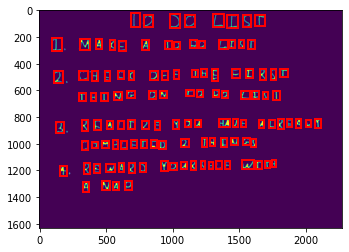

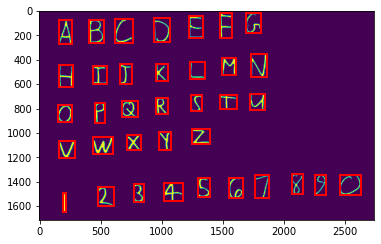

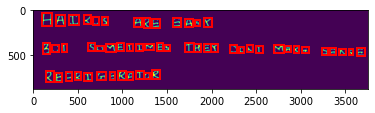

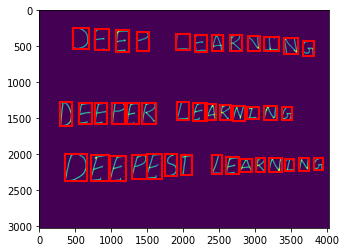

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches

# from ipynb.fs.defs.q2 import *
import import_ipynb
from q2 import *

# do not include any more libraries here!
# no opencv, no sklearn, etc!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

for img in os.listdir('images'):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images',img)))
    bboxes, bw = findLetters(im1)

    plt.imshow(bw)
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.show()
    # find the rows using..RANSAC, counting, clustering, etc.
    # YOUR CODE HERE

    bboxes = sorted(bboxes, key=lambda x: x[0])
    pre_y1, pre_x1, pre_y2, pre_x2 = bboxes[0]
    rows = [[bboxes[0]]]

    for i in range(1, len(bboxes)):
        y1, x1, y2, x2 = bboxes[i]
        if (y1 > pre_y2):
            rows.append([bboxes[i]])
        else:
            rows[-1].append(bboxes[i])
        pre_y1, pre_x1, pre_y2, pre_x2 = y1, x1, y2, x2

    for i in range(0, len(rows)):
        rows[i] = sorted(rows[i], key=lambda x: x[1])

    # raise NotImplementedError()
    # crop the bounding boxes
    # note.. before you flatten, transpose the image (that's how the dataset is!)
    # consider doing a square crop, and even using np.pad() to get your images looking more like the dataset
    # YOUR CODE HERE

    crops_r = []
    for row in rows:
        crops = []
        for bbox in row:
            y1, x1, y2, x2 = bbox
            half_side = int(max(y2-y1, x2-x1)/2)
            cen_y = int((y1+y2)/2)
            cen_x = int((x1+x2)/2)
            crop = bw[cen_y-half_side: cen_y+half_side, cen_x-half_side: cen_x+half_side]*(-1.)
            crop = skimage.transform.resize(crop, (24, 24))
            crop = np.pad(crop, ((4, 4), (4, 4)), constant_values=crop.max())
            crop = crop.transpose().flatten()
            crops.append(crop)
        crops = np.array(crops)
        crops = (crops-np.mean(crops, axis=1).reshape(-1, 1))/np.std(crops, axis=1).reshape(-1, 1)
        crops_r.append(crops)

    # raise NotImplementedError()


### Q4.4 (13 points Code+WriteUp)
Now you will load the image, find the character locations, classify each one with the network you trained in **Q3.1**, and return the text contained in the image. Be sure you try to make your detected images look like the images from the training set. Visualize them and act accordingly. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

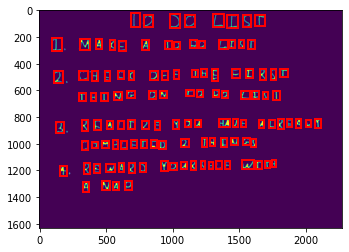

01_list.jpg
7QDOLIQT
INAREATDDDLIQ8
2LH2ERQEE8HER8RQ8
8H8NGQNTQDQEIQ7
3R2AE82EX0UM6EA6R6ADX
EQMP6886DZ1H8NGQ
5R8WARDX0URQE6EWD8B
ANAR



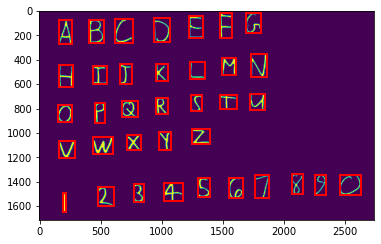

02_letters.jpg
AB6DE8G
HI8RLRN
08QRQTU
VWXXZ
8Z3QS6383Q



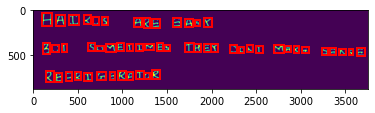

03_haiku.jpg
HAIR6QAREGASX
BQ7SQMETIMESTREXDDNTMAKESENQE
RBFRIGERA8QR



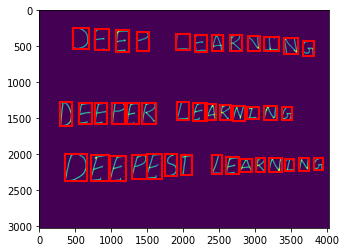

04_deep.jpg
DEE8LEARBING
DEEBERLBARNING
DEERES8LEARRING



In [5]:
# load the weights
# run the crops through your neural network and print them out
import pickle
import string
import numpy as np

letters = np.array([_ for _ in string.ascii_uppercase[:26]] + [str(_) for _ in range(10)])
params = pickle.load(open('q3_weights.pickle','rb'))
# YOUR CODE HERE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

for img in os.listdir('images'):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images',img)))
    bboxes, bw = findLetters(im1)

    plt.imshow(bw)
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.show()
    # find the rows using..RANSAC, counting, clustering, etc.
    # YOUR CODE HERE

    bboxes = sorted(bboxes, key=lambda x: x[0])
    pre_y1, pre_x1, pre_y2, pre_x2 = bboxes[0]
    rows = [[bboxes[0]]]

    for i in range(1, len(bboxes)):
        y1, x1, y2, x2 = bboxes[i]
        if (y1 > pre_y2):
            rows.append([bboxes[i]])
        else:
            rows[-1].append(bboxes[i])
        pre_y1, pre_x1, pre_y2, pre_x2 = y1, x1, y2, x2

    for i in range(0, len(rows)):
        rows[i] = sorted(rows[i], key=lambda x: x[1])

    # raise NotImplementedError()
    # crop the bounding boxes
    # note.. before you flatten, transpose the image (that's how the dataset is!)
    # consider doing a square crop, and even using np.pad() to get your images looking more like the dataset
    # YOUR CODE HERE

    crops_r = []
    for row in rows:
        crops = []
        for bbox in row:
            y1, x1, y2, x2 = bbox
            half_side = int(max(y2-y1, x2-x1)/2)
            cen_y = int((y1+y2)/2)
            cen_x = int((x1+x2)/2)
            crop = bw[cen_y-half_side: cen_y+half_side, cen_x-half_side: cen_x+half_side]*(-1.)
            crop = skimage.transform.resize(crop, (24, 24))
            crop = np.pad(crop, ((4, 4), (4, 4)), constant_values=crop.max())
            crop = crop.transpose().flatten()
            crops.append(crop)
        crops = np.array(crops)
        crops = (crops-np.mean(crops, axis=1).reshape(-1, 1))/np.std(crops, axis=1).reshape(-1, 1)
        crops_r.append(crops)

    # raise NotImplementedError()

    print(img)
    for crops in crops_r:
        h1 = forward(crops, params, 'layer1')
        probs = forward(h1, params, 'output', softmax)
        output = letters[np.argmax(probs, axis=1)]
        output = ''.join(output)
        print(output)
    print()

# raise NotImplementedError()